# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Given the known salary for a big set of Job ID listings along with some known (relevant) features, i.e. Company ID, Job Type, Degree, Major, Industry, Years Experience, and Distance from Metropolitan, we would would like to develop a machine learned statistical model to predict the salary for another dataset of Job ID postings with the same features as the ones for jobs having known salaries. In other words, we train our model based on the Job ID dataset with known salaries and, then, test it on the Job ID dataset with unknown salaries. This is a supervised machine learning problem for lots of applications like glassdoor in order to predict salary for any given Job ID, e.g. position.

Let's import the neccessary modules for data manipulation, visual representation, and machine learning algorithms.

In [1]:
import numpy as np

import scipy as sp
from scipy.sparse import csr_matrix, hstack
from scipy.stats import *

import pandas as pd
from pandas.plotting import scatter_matrix

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

from sklearn.preprocessing import PolynomialFeatures, StandardScaler  
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import partial_dependence, plot_partial_dependence

from xgboost import XGBRegressor 
from pdpbox import pdp, get_dataset, info_plots

plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# author's contact information
__author__ = "Ashoordin Ashoormaram"
__email__ = "a.ashoormaram@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----
Importing the data into a Pandas dataframe making sure it is updated on a daily basis if applicable for the corresponding business problem.

In [2]:
#training data
train_features = pd.read_csv('data/train_features.csv')
train_salaries = pd.read_csv('data/train_salaries.csv')

#testing data
test = pd.read_csv('data/test_features.csv')

#merge features and salaries of the train dataset
train = pd.merge(train_features, train_salaries, on='jobId')

### ---- 3 Clean the data ----

Check to see if there is any missing data in the dataset. Check the type of our features. Are there any data inconsistencies? Check to see if there are any missing values in our dataset. Check for duplicate data.

In [3]:
train.dropna().info()
train.dtypes
train.isnull().any()
train.duplicated().any()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
salary                 False
dtype: bool

False

Check for invalid data (salaries <=0), (milesFromMetropolis <0), and (yearsExperience <0). If there is, get names of indexes of the corresponding column features and delete those rows if they are few in number.

In [4]:
invalid_salary = sum(n <= 0 for n in train.salary)
print("invalid_salary:", invalid_salary)

invalid_milesFromMetropolis = sum(n < 0 for n in train.milesFromMetropolis)
print("invalid_milesFromMetropolis:", invalid_milesFromMetropolis)

invalid_yearsExperience = sum(n < 0 for n in train.yearsExperience)
print("invalid_yearsExperience:", invalid_yearsExperience)

train.query('salary == %d' %0)
indexNames = train[ train['salary'] == 0 ].index
train.drop(indexNames, inplace=True)
train.reset_index(drop=True, inplace=True)

invalid_salary: 5
invalid_milesFromMetropolis: 0
invalid_yearsExperience: 0


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


### ---- 4 Explore the data (EDA) ----

Let's summarize each feature variable, the target variable, look for correlation between each feature and the target as well as the correlation between features through the following actions: 

* The total number (and individual distinc values) for each variable and independent variable, 
* Summarize the statistical description of target, "salary," for each feature, and 
* The fraction of the "NONE" values for any feature.

In [5]:
train.nunique()

def unique_values(col):
    print('unique values: {}\n'.format(train[col].unique()))
        
def salary_statistics_by_feature(col):
    with pd.option_context('display.colheader_justify','left'):
        print('{}'.format(train.groupby(col)['salary'].describe()))
        
def NONE_values_by_feature(col):
    print('No. of NONE values: {}'.format(sum(n=='NONE' for n in train[col].values)))

train_features = ['companyId', 'jobType', 'degree', 'major', 
                  'industry', 'yearsExperience', 'milesFromMetropolis', 'salary']  
for col in train_features:
    print('\n\n\n\033[1m{}:\033[0m'.format(col))
    NONE_values_by_feature(col)
    unique_values(col)
    salary_statistics_by_feature(col)

jobId                  999995
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
salary                    279
dtype: int64




companyId:
No. of NONE values: 0
unique values: ['COMP37' 'COMP19' 'COMP52' 'COMP38' 'COMP7' 'COMP15' 'COMP24' 'COMP20'
 'COMP41' 'COMP56' 'COMP4' 'COMP54' 'COMP57' 'COMP14' 'COMP61' 'COMP58'
 'COMP3' 'COMP44' 'COMP30' 'COMP27' 'COMP34' 'COMP11' 'COMP31' 'COMP49'
 'COMP0' 'COMP1' 'COMP36' 'COMP47' 'COMP8' 'COMP42' 'COMP50' 'COMP53'
 'COMP48' 'COMP45' 'COMP46' 'COMP2' 'COMP5' 'COMP55' 'COMP29' 'COMP40'
 'COMP33' 'COMP22' 'COMP12' 'COMP25' 'COMP6' 'COMP23' 'COMP17' 'COMP28'
 'COMP21' 'COMP26' 'COMP43' 'COMP51' 'COMP10' 'COMP59' 'COMP13' 'COMP39'
 'COMP16' 'COMP9' 'COMP32' 'COMP62' 'COMP35' 'COMP18' 'COMP60']

           count    mean        std        min   25%   50%    75%    max  
companyId                                                                 
COMP0      15666.0  115.963615  38.604597  20.0  89.0  114.0  141.0  285.0
COMP1      15820.0  116.048609  38.424871  20.0  89.0  114.0  141.0  292.0
COMP10     15909.0  116.019800  38.782127  24.0  89.0  114.0  141.0  278.0
COMP11 

No. of NONE values: 0
unique values: [83 73 38 17 16 31 24 70 54 68 30 79 29 26 81  8 91 43 66 99 96 62 69 63
 40  6 23  9  2 32 78 14 58 35 93 82 87 76 22 44 72  4 25 36  5 71 65 53
 13 33 55 61 98 59 15 75 56 11 12 34 21 52 46 48 97 28 94 41 74 60 95 80
 89 10 50 49  3 88 47 51 18 92 42 39 67 84 86  0 19 20 57 37 64  1 27 77
 90 45 85  7]

                     count    mean        std        min   25%    50%    \
milesFromMetropolis                                                       
0                    10123.0  135.571175  41.096969  29.0  106.0  134.0   
1                    10091.0  135.494203  41.307148  29.0  106.0  133.0   
2                    10031.0  134.930615  41.274564  32.0  105.5  133.0   
3                    10106.0  134.737582  40.662330  31.0  106.0  133.0   
4                    10001.0  134.839916  41.109698  29.0  105.0  133.0   
...                      ...         ...        ...   ...    ...    ...   
95                   10125.0   98.025580  32.977865  19.

In order to answer the following questions:
* What features correlate the most with salary?
* What other correlations did you find?
* Make sure to specify some features that you might want to focus on or the plots might be too big

Let's plot Box and Whisker Plots of numerical features, the correlation between the 'salary' and all the other features. 

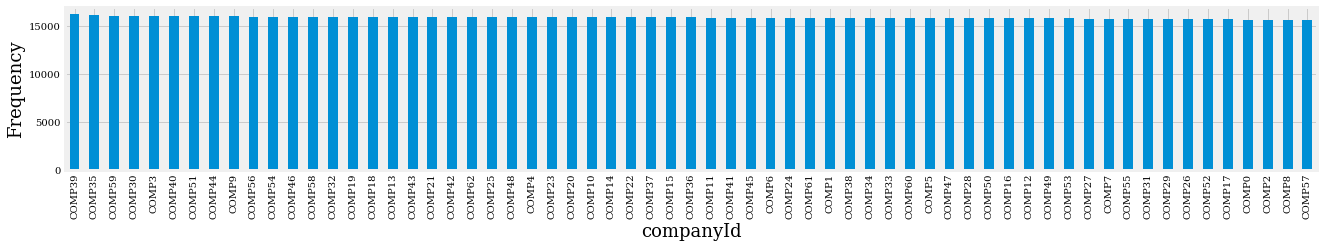

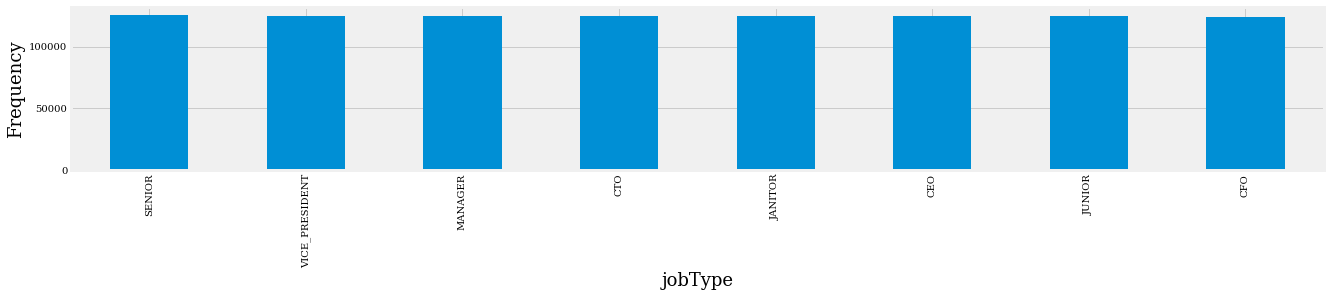

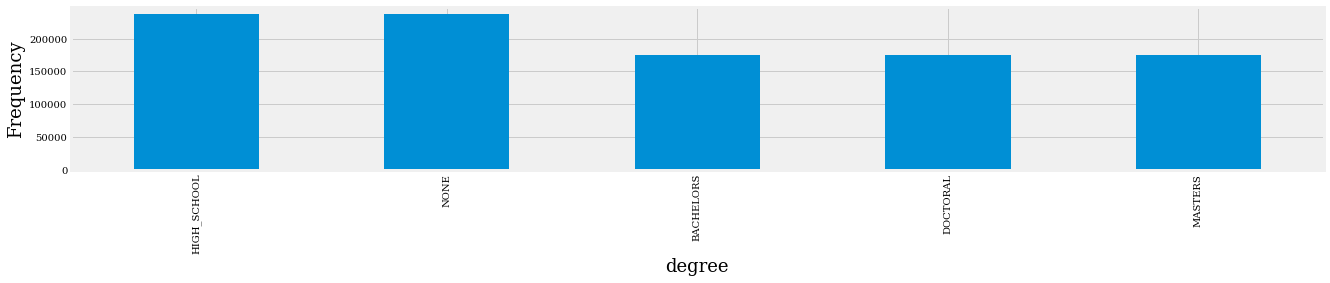

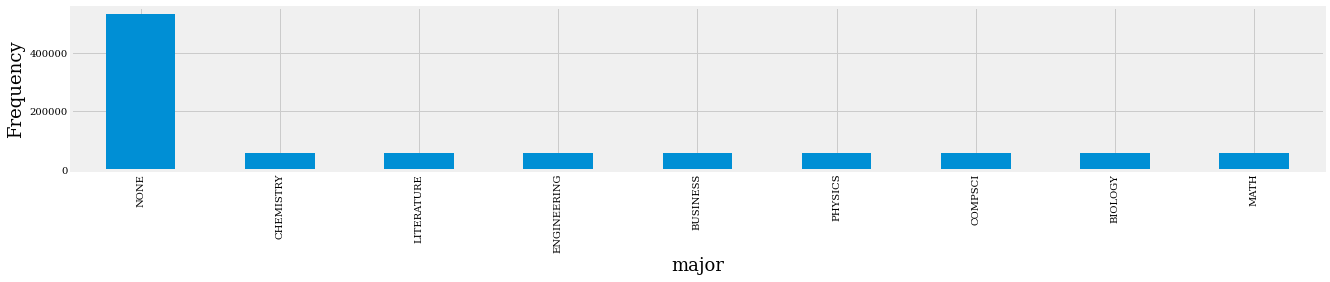

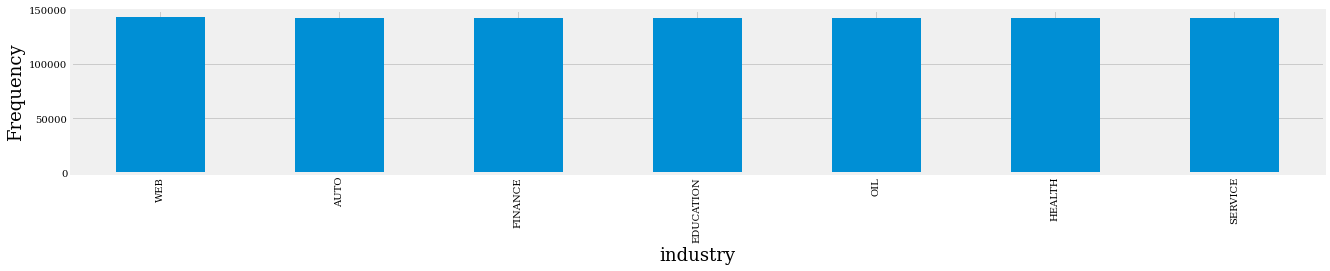

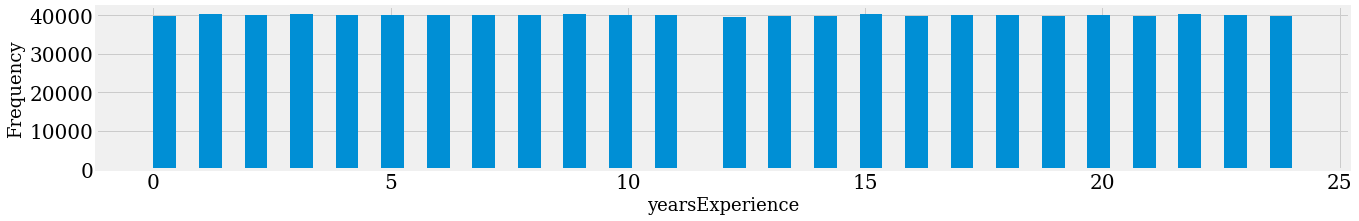

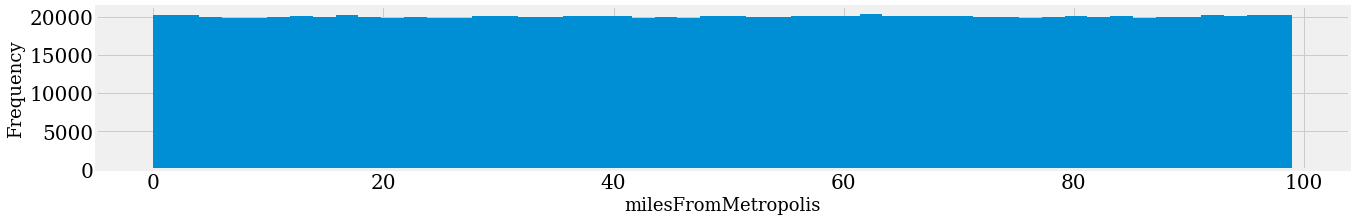

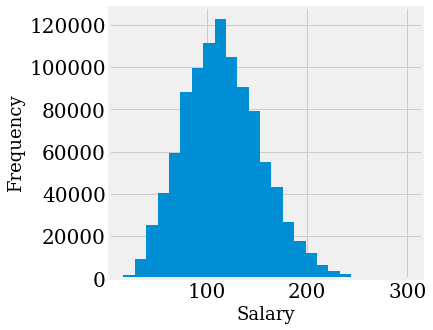

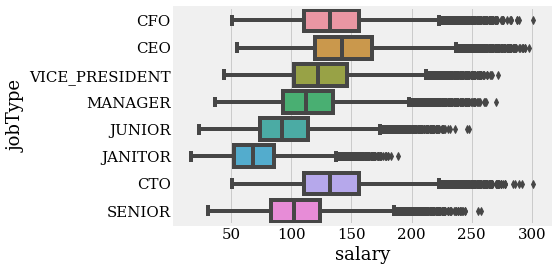

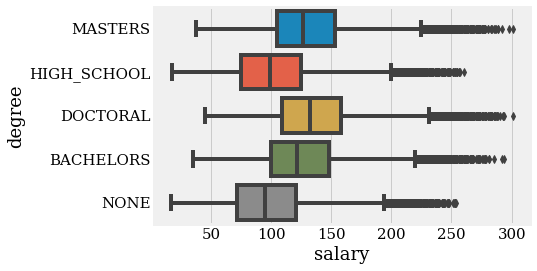

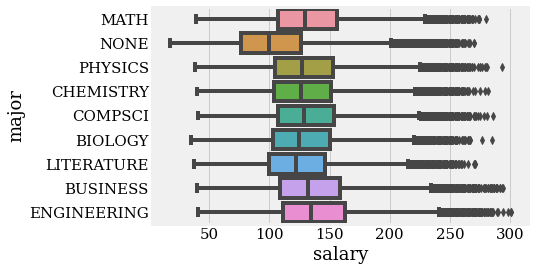

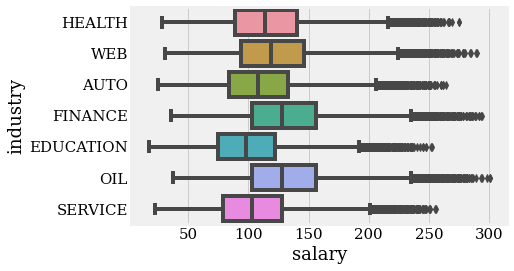

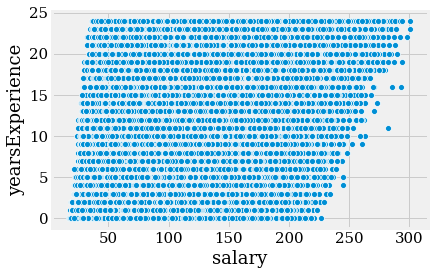

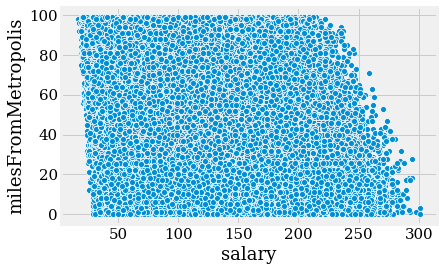

In [6]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}         
mpl.rc('font', **font) #set the font style created

# bar plots of individual columns
for col in train_features:
    if col != 'salary':
        if col not in ['yearsExperience', 'milesFromMetropolis']:
            ax = train[col].value_counts().plot(kind='bar', fontsize=10, figsize=(20,3))
            my_xlabel = ax.set_xlabel("{}".format(col))
            my_ylabel = ax.set_ylabel("Frequency")
            plt.show() #savefig('images/{}_barplot.png'.format(col))
        else:
            ax = train[col].hist(bins=50, xlabelsize=20, ylabelsize=20, figsize=(20,3))
            my_xlabel = ax.set_xlabel("{}".format(col))
            my_ylabel = ax.set_ylabel("Frequency")
            plt.show() #savefig('images/{}_barplot.png'.format(col))
            
    else:
        ax = train.salary.hist(bins=25, xlabelsize=20, ylabelsize=20, figsize=(5,5))
        my_xlabel = ax.set_xlabel("Salary")
        my_ylabel = ax.set_ylabel("Frequency")
        plt.show()

# distribution of dependent variable grouped by category
for col in train_features[1:-1]:
    if col not in ['yearsExperience', 'milesFromMetropolis']:
        ax = sns.boxplot(x="salary", y=col, data=train)
        plt.show()
    else:
        ax = sns.scatterplot(x="salary", y=col, data=train)
        plt.show()

Just like "jobId", "companyId" has no affect on the predictions of salaries. So, I could safely remove them in order to reduce the possible number of categorical features to make a more simple modle for a lower computational cost.

For both "train" and "test" datasets, **object** must be converted into **categorical** data type.

In [7]:
train_data = train.copy()
for col in ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']:
    train_data[col] = train_data[col].astype('category')

# turn 'objects' into 'categoricals' for test dataset
test_data = test.copy()
for col in ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']:
    test_data[col] = test_data[col].astype('category')

* categorical features:
    'jobType', 'degree', 'major', 'industry'

    * ordinal: 
    "jobType", "degree" 
    
    * onehot: 
    "major", "industry"

In [8]:
# Train Dataset
train_data = train_data.drop(['jobId', 'companyId'], axis=1)
train_data_NonEngineered = train_data.copy()

# replace ordinal categorical features in place
replace_map = {'degree': {'NONE': 1, 'HIGH_SCHOOL': 2, 'BACHELORS': 3, 'MASTERS': 4, 'DOCTORAL': 5}, 
               'jobType': {'JANITOR':1, 'JUNIOR':2, 'SENIOR':3, 'MANAGER':4, 'VICE_PRESIDENT':5, 'CFO':6, 'CTO':7, 'CEO':8}
              }
              #'major': {'MATH': 1, 'NONE':2, 'PHYSICS':3, 'CHEMISTRY':4, 'COMPSCI':5, 'BIOLOGY':6, 'LITERATURE':7, 'BUSINESS':8, 'ENGINEERING':9}, 'industry': {'HEALTH':1, 'WEB':2, 'AUTO':3, 'FINANCE':4, 'EDUCATION':5, 'OIL':6, 'SERVICE':7}
train_data_NonEngineered.replace(replace_map, inplace=True)


#train_data_NonEngineered = train_data_NonEngineered.copy()
# generate binary values using get_dummies to onehot encode the non-ordinal categorical features
train_data_Engineered = pd.get_dummies(train_data_NonEngineered)  

#taking salary "target" to the end of table
columnsName = list(train_data_Engineered.columns)
salary, last = columnsName.index('salary'), columnsName.index(columnsName[-1])
columnsName[salary], columnsName[last] = columnsName[last],columnsName[salary]
train_data_Engineered = train_data_Engineered[columnsName]

# Test Dataset
test_data = test_data.drop(['jobId', 'companyId'], axis=1)
test_data_NonEngineered = test_data.copy()
test_data_NonEngineered.replace(replace_map, inplace=True)
test_data_NonEngineered = test_data_NonEngineered.copy()

# generate binary values using get_dummies to onehot encode 
# the non-ordinal categorical features
test_data_Engineered = pd.get_dummies(test_data_NonEngineered)

Here is the the final "train" and "test" data after feature engineering:

In [9]:
train_data_Engineered.tail()
test_data_Engineered.tail()

,jobType,degree,yearsExperience,milesFromMetropolis,industry_WEB,major_BIOLOGY,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,salary
999990,5,3,19,94,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,88
999991,7,2,12,35,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,160
999992,2,2,16,81,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,64
999993,6,4,6,5,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,149
999994,2,3,20,11,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,88


,jobType,degree,yearsExperience,milesFromMetropolis,major_BIOLOGY,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
999995,5,3,14,3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
999996,4,1,20,67,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
999997,1,1,1,91,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
999998,7,5,14,63,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
999999,2,1,16,31,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


Let's reduce memory usage according to the [Kaggle](https://www.kaggle.com/gemartin/load-data-reduce-memory-usage) function.

In [10]:
from helper_functions import reduce_mem_usage as rmu
train_data_Engineered = rmu.reduce_mem_usage(train_data_Engineered)
test_data_Engineered = rmu.reduce_mem_usage(test_data_Engineered)

Now, Let's observe the mutual correlatin among features and target variables in order to establish a baseline model:

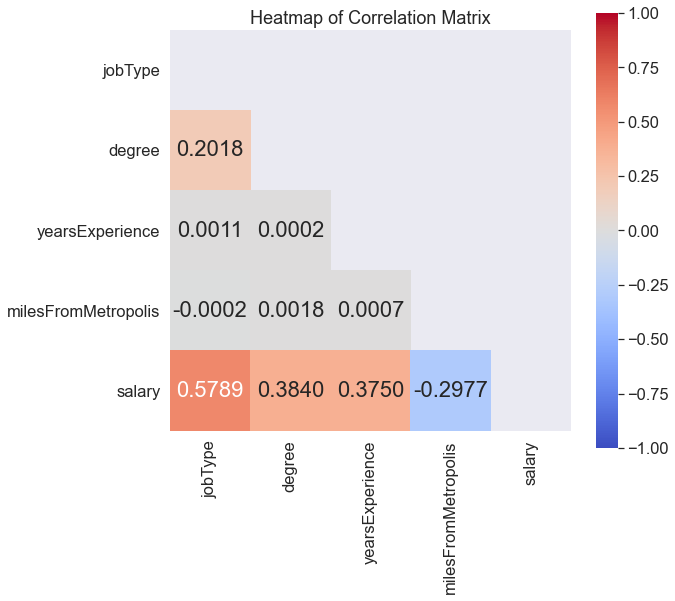

In [11]:
corr = train_data_NonEngineered[['jobType', 'degree', 'yearsExperience', 'milesFromMetropolis', 'salary']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.set(font_scale=1.5)
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values, 
            yticklabels=corr.columns.values,
            vmin=-1, vmax=1, center= 0, square=True, cmap= 'coolwarm', 
            annot = True, mask=mask, fmt='0.4f', annot_kws= {'size': 22}
                    )
    
    my_title = ax.set_title('Heatmap of Correlation Matrix')
    plt.show()

### ---- 5 Establish a baseline ----
We are assuming that the only feature that will determine the salary is "industry". Given the complexity of the problem where salary actually depends on all features (except "jobId" and "companyId") and that most of them are categoricals, in this baseline, we can ignore all but "industry" and then assign _mean_ value of each individual "industry" to all rows having that same "industry". The reasonable metric to select in this case is _mean squared error (MSE)_ since the problem is a *_regression_* one where the _numerical, continuous_ target depends on a set of features. I measured the efficacy of this simplistic model.

In [12]:
from helper_functions import baseline_algorithm_regression as baseline
baseline.baseline_algorithm_regression(train_data, 'salary', 'industry', test_data)

True Values=[130 101 137 ...  64 149  88]
Predicted Values=[116 122 116 ...  99 116  99]
Mean Squared Error=1367.244614223071


Let's split-out "train" dataset into "train" and "validation" subsets and create some initial models based on the reduced version of "train" dataset where "jobId" and "companyId" are removed and all categorical features are encoded.

knr: 452.1 (1.9)
linreg: 394.7 (0.9)
ridge: 394.7 (0.9)
lasso: 447.4 (1.3)
dtr: 699.9 (1.9)
gbr: 368.3 (1.0)
xgbr: 359.5 (0.8)
rfr: 613.7 (1.0)


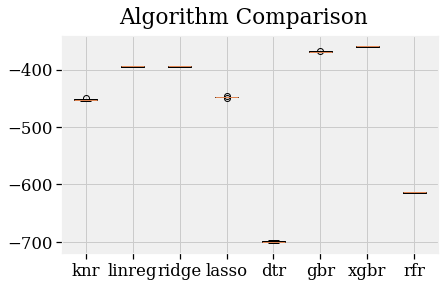

In [13]:
data = train_data_Engineered.values
n_features = len(train_data_Engineered.columns)-1
salary_features = data[:,:n_features] 
salary_target = data[:,n_features]
validation_size = 0.20
seed = 7

features_train, features_validation, target_train, target_validation = train_test_split(
    salary_features, salary_target, test_size=validation_size, random_state=seed)

# Create model shells  
models = []
models.append(('knr', KNeighborsRegressor()))
models.append(('linreg', LinearRegression()))
models.append(('ridge', Ridge()))
models.append(('lasso', Lasso()))
models.append(('dtr', DecisionTreeRegressor()))
models.append(('gbr', GradientBoostingRegressor()))
models.append(('xgbr', XGBRegressor()))
models.append(('rfr', RandomForestRegressor(n_estimators=10, max_depth=5)))

# Spot test each model with Cross-validation evaluating each model in turn
results, names = [], []
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
for name, model in models:
    cv_results = cross_val_score(model, features_train, target_train, cv=kfold, 
                                 scoring='neg_mean_squared_error', n_jobs=-1)  
    results.append(cv_results)
    names.append(name)
    print('{}: {:.1f} ({:.1f})'.format(name, -1*cv_results.mean(), cv_results.std()))
    
# Graphical comparison of algorithms
fig = plt.figure()
my_subtitle = fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
my_boxplot = plt.boxplot(results)
my_xticklabels = ax.set_xticklabels(names)
plt.show()

### ---- 6 Hypothesize solution ----

The Algorithms I considered were, **_Lasso_**, **_RandomForestRegressor_**, **_DecisionTreeRegressor_**,**_LinearRegressor_**, **_Ridge_**, **_GradientBoostingRegressor_**, **_XGBRegressor_**, and **_KNeighborsRegressor_**. After spot testing each model with ```Cross-validation``` evaluating each model in turn, I chose the three highest-score algorithms producing the least *mean squared error*, (*MSE*) as our metric of the problem:

* **_Ridge_**
* **_GradientBoostingRegressor_**
* **_XGBRegressor_**

One can find the most important features in predicting salaries. Since _RandomizedSearch_ 
* does a good job finding near-optimal hyper-parameters over a very large search space relatively quickly, 
* doesn't suffer from the same exponential scaling problem as _GridSearch,_ and 
* does not test every possible combination of parameters,  

I am using it first to extract some overall good patameter combination for later fine-tuning the results using _GridSearch_. To do so, here is the proceedure:

* Determining Estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data.
* Parameter setting that gave the best results on the hold out data.
* Mean cross-validated score of the best_estimator
* Return the score on the validation data

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

I will cycle through creating features, tuning models, and training/validing models (steps 7-9) until I've reached the efficacy goal:

#### Our metric is chosen to be MSE and our goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 8 Create models ----

In [14]:
from helper_functions import randomized_search as rs

# initializing the parameter combinations for RandomizedSearch
for model, distribution in [(Ridge(), dict(alpha=uniform(loc=0.001, scale=20.001))), 
                            (GradientBoostingRegressor(), dict(learning_rate=uniform(loc=0, scale=1.0), 
                                                               max_features=randint(low=2, high=21),
                                                               max_depth=randint(low=2, high=10))), 
                            (XGBRegressor(), dict(learning_rate=uniform(loc=0, scale=1.0), 
                                                  max_depth=randint(low=2, high=10),       
                                                  n_estimators=randint(low=10, high=101)))]:
    
    rs.randomized_search(model, distribution, features_train, target_train, features_validation, target_validation)

Best estimator:
Ridge(alpha=0.49439934207678154)            
Best parameters:
{'alpha': 0.49439934207678154}            
Best cross-validation score: 394.659            
Best test score: 393.307


Best estimator:
GradientBoostingRegressor(learning_rate=0.17329014618393446, max_depth=6,
                          max_features=13)            
Best parameters:
{'learning_rate': 0.17329014618393446, 'max_depth': 6, 'max_features': 13}            
Best cross-validation score: 358.482            
Best test score: 356.988


Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.424089078631793, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=98, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg

### ---- 9 Test models ----

Now that we have an idea of the overall ranges of best parameters, we can do a finer search by using _GridSearchCV_ instead of _RandomizedSearchCV_ as well as preprocessing our data using _polynomialFeatures_ of degree 2 for **_Ridge_** model.

In [15]:
for model, param_grid in [(Ridge(), {'polynomialfeatures__degree': [1, 2],
                                     'ridge__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1]}),
                          (GradientBoostingRegressor(), {'polynomialfeatures__degree': [1],
                                                         'gradientboostingregressor__learning_rate': [0.1, 0.2, 0.3, 0.4], 
                                                         'gradientboostingregressor__max_depth': [4, 5, 6]}),
                          (XGBRegressor(), {'polynomialfeatures__degree': [1],
                                            'xgbregressor__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8],
                                            'xgbregressor__max_depth': [4, 5, 6]})]:
    pipe = make_pipeline(PolynomialFeatures(interaction_only=True, include_bias=False), model)
    
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=6, scoring='neg_mean_squared_error')
    grid.fit(features_train, target_train)
   
    print('model:', model)
    # determine the best parameters trained on the whole training set for each model
    print("Best parameters: {}".format(grid.best_params_))
    # evaluate how well the best found parameters generalize
    print("Test-set score: {:.3f}\n\n".format(-1*grid.score(features_validation, target_validation)))

GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('ridge', Ridge())]),
             n_jobs=6,
             param_grid={'polynomialfeatures__degree': [1, 2],
                         'ridge__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1]},
             scoring='neg_mean_squared_error')

model: Ridge()
Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 0.1}
Test-set score: 362.520




GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             n_jobs=6,
             param_grid={'gradientboostingregressor__learning_rate': [0.1, 0.2,
                                                                      0.3,
                                                                      0.4],
                         'gradientboostingregressor__max_depth': [4, 5, 6],
                         'polynomialfeatures__degree': [1]},
             scoring='neg_mean_squared_error')

model: GradientBoostingRegressor()
Best parameters: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 6, 'polynomialfeatures__degree': 1}
Test-set score: 356.367




GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interac...
                                                     num_parallel_tre

model: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)
Best parameters: {'polynomialfeatures__degree': 1, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 6}
Test-set score: 356.015




### ---- 10 Select best model  ----

Even the introduction of interaction-terms of a 2nd degree polynomial to the list of features for a _Liear_ **_Ridge_** model is not as good as **_GradientBoostingRegressor_** or **_GBRegressor_**. So, I proceeded with the former given the _best parameters_ above.

To differentiate possible levels a data scientist can have, these conditions should be met:
* There are 4 levels: "entry-level," "junior," "senior," and "principal" with the "yearsExperience" being inside the bins [0,2], [3,4], [5,9], and [10,24]. 
* A data science role should have at least a high school degree.
* A data science role cannot have the value, "JANITOR" as its "jobType".

Let's apply the best algorithm to these subsets of "train" dataset to see if the model is accurate enough for predicting the salaries for _entry-level_ and _senior_ datascience roles. Before then, however, I added four more features into "train" data, i.e. three 2nd-degree polynomials and one 3r-degree polynomial. The reason I thought these four would be enough is that usually salary is dictated by three important features: "degree", "yearsExperience," and "jobType". So, I made products from these features to introduce new features.

In [65]:
# train
train_original = train_data_Engineered.copy()

train_original['experience_degree'] = train_original['yearsExperience'] * train_original['degree']
train_original['experience_jobType'] = train_original['yearsExperience'] * train_original['jobType']
train_original['degree_jobType'] = train_original['degree'] * train_original['jobType']
train_original['experience_degree_jobType'] = train_original['yearsExperience'] * train_original['degree'] * train_original['jobType']

#taking salary "target" to the end of table
Names = list(train_original.columns)
target_feature, last_item = Names.index('salary'), Names.index(Names[-1])
Names[target_feature], Names[last_item] = Names[last_item], Names[target_feature]
train_original = train_original[Names]

salary_features_final, salary_target_final = (train_original.values[:,:len(train_original.columns)-1], 
                                              train_original.values[:,len(train_original.columns)-1])

features_train_final, features_validation_final, target_train_final, target_validation_final = train_test_split(
    salary_features_final, salary_target_final, test_size=validation_size, random_state=seed)

pipe_xgbr_final = make_pipeline(StandardScaler(with_mean=False), 
                                XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=500, n_jobs=6, random_state=0))
cv_results_all = cross_val_score(pipe_xgbr_final, features_train_final, target_train_final, 
                                 cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)

print("Modeling Algorithm = ", "XGBRegressor")
print('{}: {:.1f} ({:.1f})'.format('all training set', -1*cv_results_all.mean(), cv_results_all.std()))

Modeling Algorithm =  XGBRegressor
all training set: 356.6 (0.7)


This is the best test set-score I had for the entire "training" dataset, i.e. before splitting the set into different levels based on the level of experience of individual data science roles. Now, using the same **_XGBRegressor_**, I will train the two subsets differently and will score the validation dataset for each level to see if I meet the required goal of the business problem.

In [66]:
train_original['yearsExperience'].loc[train_original['yearsExperience'].between(0, 1, inclusive=True)] = 1 
train_original['yearsExperience'].loc[train_original['yearsExperience'].between(2, 4, inclusive=True)] = 2
train_original['yearsExperience'].loc[train_original['yearsExperience'].between(5, 9, inclusive=True)] = 3
train_original['yearsExperience'].loc[train_original['yearsExperience'].between(10, 24, inclusive=True)] = 4

# separating entry-level and senior-level jobs for assessing the accuracy of our model
train_original_entry_1, train_original_senior_1 = (train_original[(train_original['yearsExperience'] == 1) & 
                                                                 (train_original['jobType'] != 1) &
                                                                 (train_original['degree'] != 1)], 
                                                   train_original[(train_original['yearsExperience'] == 2) &
                                                                 (train_original['jobType'] != 1) &
                                                                 (train_original['degree'] != 1)])

train_original_entry, train_original_senior = (train_original_entry_1.drop(columns=['yearsExperience']), 
                                               train_original_senior_1.drop(columns=['yearsExperience']))

salary_features_entry, salary_features_senior = (train_original_entry.values[:,:len(train_original_entry.columns)-1], 
                                                 train_original_senior.values[:,:len(train_original_senior.columns)-1])  
salary_target_entry, salary_target_senior = (train_original_entry.values[:,len(train_original_entry.columns)-1], 
                                             train_original_senior.values[:,len(train_original_senior.columns)-1])

# Train-Test-Split for entry-level subset of data
features_train_entry, features_validation_entry, target_train_entry, target_validation_entry = train_test_split(
    salary_features_entry, salary_target_entry, test_size=validation_size, random_state=seed)
# Train-Test-Split for entry-level subset of data
features_train_senior, features_validation_senior, target_train_senior, target_validation_senior = train_test_split(
    salary_features_senior, salary_target_senior, test_size=validation_size, random_state=seed) 

# Cross-Validation scoring of entry-level roles
cv_results_entry = cross_val_score(pipe_xgbr_final, features_train_entry, target_train_entry, 
                                   cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
# Cross-Validation scoring of senior-level roles
cv_results_senior = cross_val_score(pipe_xgbr_final, features_train_senior, target_train_senior, 
                                    cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)

print("Modeling Algorithm = ", "XGBRegressor")
print('{}: {:.1f} ({:.1f})'.format('Entry-Level', -1*cv_results_entry.mean(), cv_results_entry.std()))
print('{}: {:.1f} ({:.1f})\n\n'.format('Senior', -1*cv_results_senior.mean(), cv_results_senior.std()))

Modeling Algorithm =  XGBRegressor
Entry-Level: 290.6 (6.0)
Senior: 311.6 (2.3)




Now, that the goal is met (even better than our original goal of 360 for _entry-level_ and 320 for _senior_ data science roles), and we have the best parameters of **_XGBRegressor_** for the entire dataset, let's predict the salaries of the "test" data based on the best-fit model obtained earlier.

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [67]:
# Align "train" and "test" datasets
test_original = test_data_Engineered.copy()
test_original['yearsExperience'].loc[test_original['yearsExperience'].between(0, 2, inclusive=True)] = 1 
test_original['yearsExperience'].loc[test_original['yearsExperience'].between(3, 4, inclusive=True)] = 2
test_original['yearsExperience'].loc[test_original['yearsExperience'].between(5, 9, inclusive=True)] = 3
test_original['yearsExperience'].loc[test_original['yearsExperience'].between(10,24, inclusive=True)] = 4

test_original['experience_degree'] = test_original['yearsExperience'] * test_original['degree']
test_original['experience_jobType'] = test_original['yearsExperience'] * test_original['jobType']
test_original['degree_jobType'] = test_original['degree'] * test_original['jobType']
test_original['experience_degree_jobType'] = test_original['yearsExperience'] * test_original['degree'] * test_original['jobType']

test_original['salary'] = 0
test_original = test_original[train_original.columns]
test_dataset = test_original.iloc[:, :-1].values

pipe_xgbr_final.fit(salary_features_final, salary_target_final)
predictions = np.rint(pipe_xgbr_final.predict(test_dataset))
test['salary'] = predictions

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=4, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=6, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

I am saving my prediction to a csv file:

In [68]:
#save your prediction to a csv file
test.to_csv(path_or_buf='Predicted_Salaries.csv', columns=None, header=True, index=False)

### ---- 12 Deploy solution ----

Additionally, let's save little more visualizations and summary of the predictions and feature importances which will be extremely useful to business stakeholders.

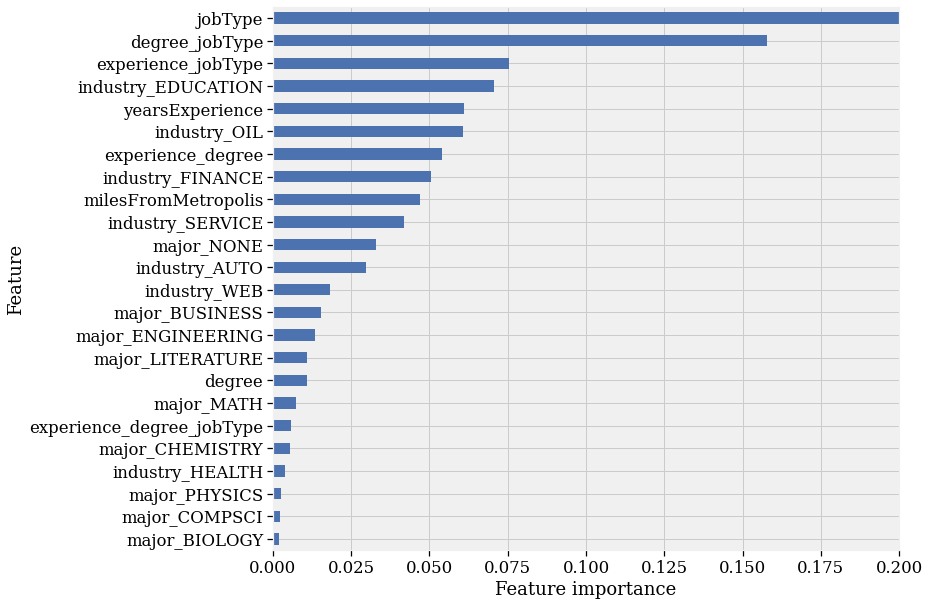

In [69]:
feature_importances = pd.Series(pipe_xgbr_final[1].feature_importances_, index=train_original.iloc[:, :-1].columns)
#print(feature_imrtances)
feature_importances.sort_values(inplace=True)
ax = feature_importances.plot(kind='barh', figsize=(10,10), 
                              xlim=[0, round(pipe_xgbr_final[1].feature_importances_.max(), 1)], 
                              ylim=[-1, n_features], 
                              label=pipe_xgbr_final[1].__class__.__name__)
my_x_label = ax.set_xlabel("Feature importance")
my_y_label = ax.set_ylabel("Feature")
ax.get_figure().savefig("images/Feature_Importances_all.png", dpi=None, facecolor='w', edgecolor='w', 
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches='tight', pad_inches=0,
            frameon=None, metadata=None)

Let's create combined feature importances as well:

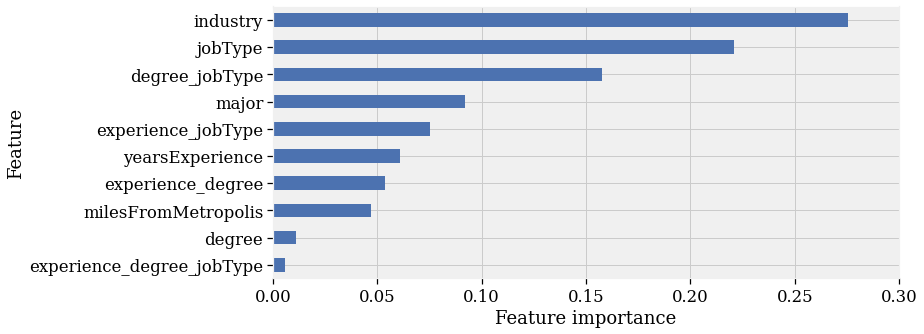

In [70]:
from helper_functions import graph_feature_importances as gfi
categorical_variables = ["major", "industry"]
gfi.graph_feature_importances(pipe_xgbr_final[1], train_original.columns, summarized_columns=categorical_variables)

Aside from engineered features, i.e. _degree\*jobType_ ,  _yearsExperience\*jobType_ , _yearsExperience\*degree_ , and  _yearsExperience\*degree*jobType_ which are all added and seems to be important, the order of importance among original features seems to be _industy_ > _jobType_ > _major_ > _yearsExperience_ > _degree_. This only means that these features are important predictive but it does not say how they are important. While _feature importance_ shows what variables most affect predictions, _partial dependence_ plots show how a feature affects predictions. A few items are worth pointing out as one interprets this plot. The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value. A blue shaded area indicates level of confidence.

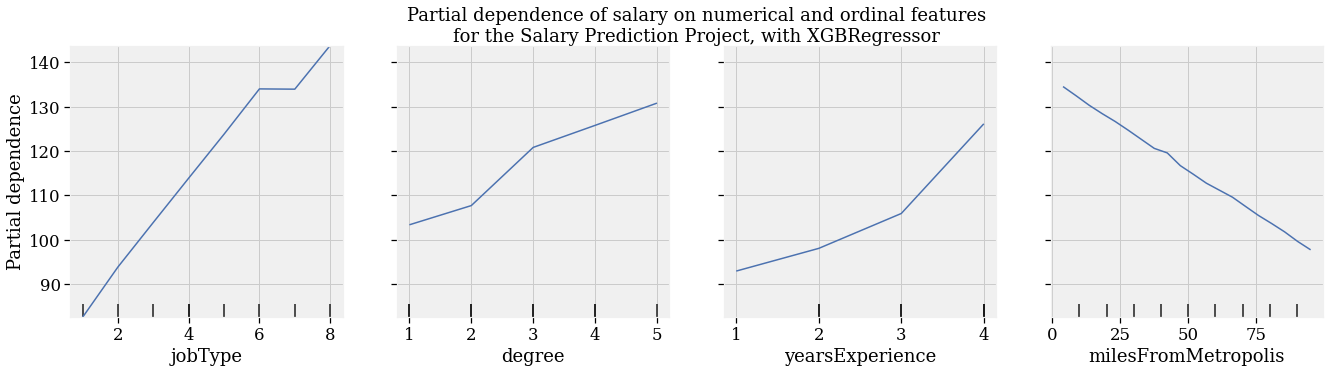

In [71]:
salary_X_colns = ["jobType", "degree", "yearsExperience", "milesFromMetropolis"]
salary_X = train_original[salary_X_colns]
model = pipe_xgbr_final[1].fit(salary_X, train_original.iloc[:,-1:])

h, ax18 = plt.subplots(figsize=(20, 5))
my_title = ax18.set_title('Partial dependence of salary on numerical and ordinal features\n'
                          'for the Salary Prediction Project, with XGBRegressor', 
                          fontsize=18, pad=0)
salary_plots = plot_partial_dependence(model, 
                                       X=salary_X, 
                                       features=["jobType", "degree", "yearsExperience", "milesFromMetropolis"], 
                                       feature_names=salary_X_colns, 
                                       method='brute', n_cols=4, grid_resolution=20, n_jobs=-1, ax=ax18)

plt.savefig("images/Scikit-Learn_Partial_Dependence_Plots.png")

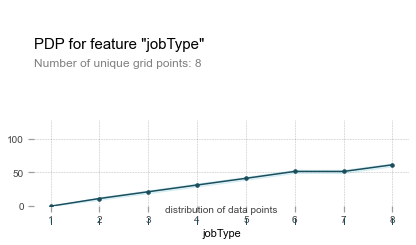

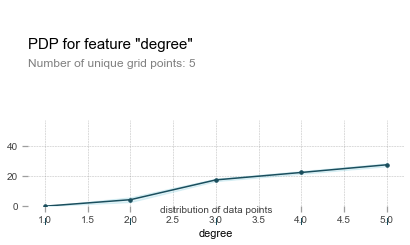

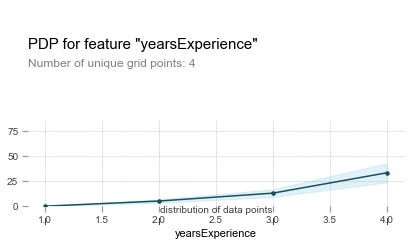

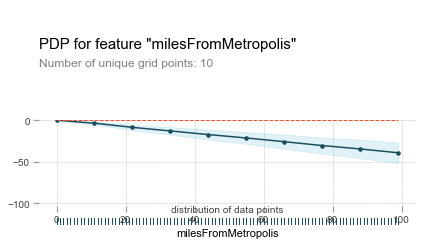

In [72]:
list_features = ["jobType", "degree", "yearsExperience", "milesFromMetropolis"]
for feat in list_features:
    pdp_salary = pdp.pdp_isolate(model, 
                                 dataset=train_original, 
                                 model_features=list_features, feature=feat)
    # generate plot
    fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_salary, feature_name=feat, 
                             plot_pts_dist=True, figsize=(6, 4))

    # save figure
    plt.savefig('images/pdp_{}.png'.format(feat))

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data